### PyTorch Torchvision: COCO 8 Instance Segmentation

In [16]:
# import libraries
import io
import gc
import os
import cv2
import pickle
import shutil
import mlflow
import torch
import torchvision
import numpy as np
import logging
import pandas as pd
from datetime import datetime
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F
from pycocotools.coco import COCO
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
from mlflow.models import infer_signature
from typing import Any, Tuple
from torchvision import datasets
from torchvision.ops.boxes import box_convert
from torch.utils.data import DataLoader
from contextlib import redirect_stdout
from torchvision.models.detection.mask_rcnn import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from PIL import Image, ImageDraw
from torchvision.datasets import coco
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from numpy import uint8
import torch.nn.functional as F2
from torchvision.ops.boxes import nms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

print(mlflow.__version__)
print(torchvision.__version__)

os.environ["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"] = "true"

2.12.1
0.16.2+cu118


In [17]:
# set the logging level for 'mlflow' to DEBUG for detailed output.
logging.getLogger("mlflow").setLevel(logging.DEBUG)

In [18]:
# basic function usage
def collate_fn(batch):
    return tuple(zip(*batch))

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]

    fig, axs = plt.subplots(ncols = len(imgs), squeeze = False)
    
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in mlflow.MlflowClient().list_artifacts(r.info.run_id, "model")]

    print(f"run_id: {r.info.run_id}")
    print(f"artifacts: {artifacts}")
    print(f"params: {r.data.params}")
    print(f"metrics: {r.data.metrics}")
    print(f"tags: {tags}")

In [19]:
# custom dataset class
class InstanceSegmentation(datasets.CocoDetection):
    def __init__(self, root, annFile, transform):
        super(InstanceSegmentation, self).__init__(root, annFile, transform)
        self.coco = COCO(annFile)
        self.dataset = self.coco.dataset
        self.v2_transform = transform
        self.annFile = annFile

    def __getitem__(self, index) -> Tuple[Any, Any]:
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        # image, target = super(InstanceSegmentation, self).__getitem__(index)

        if self.v2_transform is not None:
            height, width = image.height, image.width
            original_bounding_box = torch.tensor([t['bbox'] for t in target])
            bounding_box_xyxy = box_convert(original_bounding_box, in_fmt = 'xywh', out_fmt = 'xyxy')
            tv_tensor_bounding_box_xyxy = tv_tensors.BoundingBoxes(bounding_box_xyxy, format = "XYXY", canvas_size = (height, width))
            label = torch.tensor([t['category_id'] for t in target])
            mask_np = np.array([self.coco.annToMask(t) for t in target])
            mask = torch.tensor(mask_np)
            # refer below link for more information
            # https://pytorch.org/blog/extending-torchvisions-transforms-to-object-detection-segmentation-and-video-tasks/#the-new-transforms-api
            transform_image, transform_bounding_box, transform_mask, transform_label = self.v2_transform(image, tv_tensor_bounding_box_xyxy, mask, label)
            # transform_mask = F.resize_mask(mask, size = [250, 250])

        dic = {
            "boxes": [],
            "labels": [],
            "image_id": -1,
            "masks": []
        }

        if not all(x == target[0]["image_id"] for x in [t["image_id"] for t in target]):
            raise ValueError("Not all values are equal in the list.")
        else:
            dic["image_id"] = target[0]["image_id"] 

        dic["boxes"] = transform_bounding_box
        dic["labels"] = transform_label
        dic["masks"] = transform_mask

        return transform_image, dic

    def __len__(self) -> int:
        return len(self.ids)

    def getImgIds(self, imgIds = [], catIds = []):
        return self.coco.getImgIds(imgIds = [], catIds = [])

    def getCatIds(self, catNms = [], supNms = [], catIds = []):
        return self.coco.getCatIds(catNms = [], supNms = [], catIds = [])

    def loadAnns(self, ids = []):
        return self.coco.loadAnns(ids = ids)

    def getAnnIds(self, imgIds = [], catIds = [], areaRng = [], iscrowd = None):
        return self.coco.getAnnIds(imgIds = imgIds, catIds = catIds, areaRng = areaRng, iscrowd = iscrowd)

#### 1. Setup MLflow experiment tracking

In [20]:
# delete experiment name
# mlflow.delete_experiment(experiment_id = '1')

In [21]:
def experiment_exists(name):
    client = MlflowClient()
    experiments = client.search_experiments()

    return any([exp.name == name for exp in experiments])

experiment_name = 'coco8-instance-seg'

if not experiment_exists(experiment_name):
    experiment_description = (
        "coco 8 for faster development."
        "instance segmentation tasks. with mask rcnn model."
    )

    experiment_tag = {
        "project_name": "coco 8",
        "department": "software engineering",
        "team": "ai vision",
        "project_quarter": "Q2-2024",
        "mlflow.note.content": experiment_description,
    }

    # MLflow failed to create tags
    mlflow.create_experiment(name = experiment_name, tags = experiment_tag)

In [22]:
# setup mlflow experiment
mlflow_tracking_url = "sqlite:///mlflow.db"

mlflow.set_tracking_uri(mlflow_tracking_url)
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///D:/Git/computer-vision-deep-learning-project/project/instance_segmentation/coco8_seg/mlruns/1', creation_time=1715752257214, experiment_id='1', last_update_time=1715752257214, lifecycle_stage='active', name='coco8-instance-seg', tags={}>

In [23]:
# retrieve experiment`s information
experiment = mlflow.get_experiment_by_name(experiment_name)
experiment_id = experiment.experiment_id

print(f"name: {experiment.name}")
print(f"experiment id: {experiment.experiment_id}")
print(f"artifact location: {experiment.artifact_location}")
print(f"tags: {experiment.tags}")
print(f"lifecycle stage: {experiment.lifecycle_stage}")
print(f"creation timestamp: {experiment.creation_time}")

name: coco8-instance-seg
experiment id: 1
artifact location: file:///D:/Git/computer-vision-deep-learning-project/project/instance_segmentation/coco8_seg/mlruns/1
tags: {}
lifecycle stage: active
creation timestamp: 1715752257214


#### 2. Data Preparation

In [24]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale = True),
    # v2.Resize((250, 250)),
    v2.ToDtype(torch.float32, scale = True),
])

with redirect_stdout(io.StringIO()):
    training_dataset = InstanceSegmentation(
        # root = "dataset/first_pcb_sample/train/images", 
        # annFile = "dataset/first_pcb_sample/train/annotations/train.json",
        root = "../../../dataset/coco8-seg/train/images", 
        annFile = "../../../dataset/coco8-seg/train/annotation/_annotations.coco.json",
        transform = transform
    )
    validation_dataset = InstanceSegmentation(
        # root = "dataset/first_pcb_sample/val/images", 
        # annFile = "dataset/first_pcb_sample/val/annotations/val.json",
        root = "../../../dataset/coco8-seg/valid/images", 
        annFile = "../../../dataset/coco8-seg/valid/annotation/_annotations.coco.json",
        transform = transform
    )

training_dataloader = DataLoader(
    training_dataset, 
    batch_size = 1,
    shuffle = True,
    num_workers = 0,
    collate_fn = collate_fn
)

with redirect_stdout(io.StringIO()):
    coco_training = COCO("../../../dataset/coco8-seg/train/annotation/_annotations.coco.json")
    coco_validation = COCO("../../../dataset/coco8-seg/valid/annotation/_annotations.coco.json")

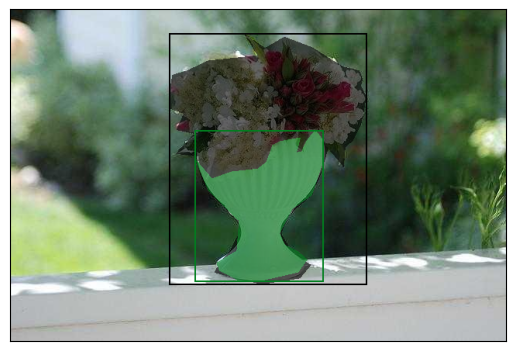

In [25]:
# visualization
train_features_batch, train_labels_batch = next(iter(training_dataloader))

image = train_features_batch[0].numpy().transpose((1, 2, 0))
ground_truth = train_labels_batch[0]['boxes']
masks = train_labels_batch[0]['masks']

# fig, ax = plt.subplots(1)
# ax.imshow(image)

# print(masks.shape)
# print(ground_truth.shape)

# for box in ground_truth:
#     rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], 
#         linewidth = 1, edgecolor = 'r', facecolor = 'none')
#     ax.add_patch(rect)

# plt.axis('off')
# plt.show()

image_uint8 = (train_features_batch[0] * 255).byte()
masks_bool = masks.bool()
result = draw_segmentation_masks(image_uint8, masks = masks_bool, alpha = 0.6)
result_with_boxes = draw_bounding_boxes(result, ground_truth, width = 2)

show(result_with_boxes)

#### 3. Model Construction

In [26]:
class_number_plus_background = len(training_dataset.coco.cats) + 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = maskrcnn_resnet50_fpn_v2(weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, class_number_plus_background)

# in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels
# model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, dim_reduced, class_number_plus_background)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

learning_rate, momentum, weight_decay = 0.005, 0.9, 0.0005
step_size, gamma = 3, 0.1
unfreeze_all_layer = True

optimizer = torch.optim.SGD(params, lr = learning_rate, momentum = momentum, weight_decay = weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)

# unfrozen, set all parameters to require gradients to true
if unfreeze_all_layer:
    for param in model.parameters():
        param.requires_grad = True

print(model)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

#### 4. Model Training

In [27]:
selected_keys = ['boxes', 'labels', 'masks']
pip_requirements = [
    'torch==2.1.2+cu118',
    'torchvision==0.16.2+cu118'
]
conda_env = {
    'name': 'mlflow-env',
    'channels': ['conda-forge'],
    'dependencies': [
        'python=3.11.9',
        'pip<=23.3.1',
        {'pip': ['mlflow==2.12.1', 'torch==2.1.2+cu118', 'cloudpickle==3.0.0']}
    ]
}

# auto log all entities
mlflow.pytorch.autolog(disable = False)

# with mlflow.start_run(tags = {"Version": 1}) as run:
with mlflow.start_run() as run:
    # log user and model detail
    mlflow.set_tag("developer", "christopher")
    mlflow.set_tag("model", "mask_rcnn_resnet50_fpn_v2")
    mlflow.set_tag("version", mlflow.__version__)

    # log training path
    mlflow.log_param("train-data-path", training_dataset.root)
    mlflow.log_param("valid-data-path", validation_dataset.root)
    mlflow.log_param("train-annotation-path", training_dataset.annFile)
    mlflow.log_param("valid-annotation-path", validation_dataset.annFile)

    # log optimizer parameter
    mlflow.log_param("optimizer", type(optimizer).__name__)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("momentum", momentum)
    mlflow.log_param("weight_decay", weight_decay)

    # log scheduler parameter
    mlflow.log_param("scheduler", type(lr_scheduler).__name__)
    mlflow.log_param("step_size", step_size)
    mlflow.log_param("gamma", gamma)

    # freeze/ unfreeze all layers
    mlflow.log_param("unfreeze_all_layer", unfreeze_all_layer)

    for epoch in range(5):
        model.train()
        train_loss = 0.0

        for batch_idx, (images, targets) in enumerate(training_dataloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items() if k in selected_keys} for t in targets]

            # forward pass
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            # backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # delete tensor and clear cache to free up memory
            del images, targets, loss_dict
            # clear system memory
            gc.collect()

        # clear cache after each epoch
        torch.cuda.empty_cache()
        # clear system memory
        gc.collect()

        # print total train loss per epoch
        total_train_loss = train_loss / len(training_dataloader)

        # log training loss
        mlflow.log_metric("total_train_loss", total_train_loss, step = (epoch + 1))

        # log model to artifact as a checkpoint
        base_dir = "model_checkpoint"
        checkpoint_path = f"{base_dir}/epoch_{epoch + 1}"
        mlflow.pytorch.log_model(model, checkpoint_path, pip_requirements = pip_requirements)

        print(f'Epoch {epoch + 1}, Loss: {total_train_loss}')
        print(f'Max allocated memory: {torch.cuda.max_memory_allocated(device) / 1024 ** 2} MB, Allocated memory: {torch.cuda.memory_allocated(device) / 1024 ** 2} MB')
        print(f'Max reserved memory: {torch.cuda.max_memory_reserved(device) / 1024 ** 2} MB, Reserved memory: {torch.cuda.memory_reserved(device) / 1024 ** 2} MB')
        print("")

    # specify path
    model_path = "model"
    scripted_model_path = "scripted_model"

    # delete the directories if they exist
    for path in [model_path, scripted_model_path]:
        shutil.rmtree(path, ignore_errors = True)

    # log/ save the model to artifact/ local
    mlflow.pytorch.log_model(model, model_path, pip_requirements = pip_requirements)
    mlflow.pytorch.save_model(model, model_path, pip_requirements = pip_requirements)

    # convert to scripted model and log/ save the model to artifact/ local
    scripted_model = torch.jit.script(model)
    mlflow.pytorch.log_model(scripted_model, scripted_model_path, pip_requirements = pip_requirements)
    mlflow.pytorch.save_model(scripted_model, scripted_model_path, pip_requirements = pip_requirements)

    # # save transform locally
    # with open('model/transform.bin', 'wb') as f_out:
    #     pickle.dump((transform), f_out)

    # # log artifact for model
    # mlflow.log_artifact(local_path = "model/transform.bin", artifact_path = "transform_pickle")

# get the auto logged parameters and metric
print_auto_logged_info(mlflow.get_run(run_id = run.info.run_id))

# default conda environment
env = mlflow.pytorch.get_default_conda_env()
print(f"conda env: {env}")

2024/05/15 13:58:11 DEBUG mlflow.utils.autologging_utils: Called autolog() method for pytorch autologging with args '()' and kwargs '{'log_every_n_epoch': 1, 'log_every_n_step': None, 'log_models': True, 'log_datasets': True, 'disable': False, 'exclusive': False, 'disable_for_unsupported_versions': False, 'silent': False, 'registered_model_name': None, 'extra_tags': None, 'checkpoint': True, 'checkpoint_monitor': 'val_loss', 'checkpoint_mode': 'min', 'checkpoint_save_best_only': True, 'checkpoint_save_weights_only': False, 'checkpoint_save_freq': 'epoch'}'
2024/05/15 13:58:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
c:\Users\christopher_hu\AppData\Local\anaconda3\envs\mlflow\Lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using d

Epoch 1, Loss: 1.529197245836258
Max allocated memory: 3526.59033203125 MB, Allocated memory: 1122.3681640625 MB
Max reserved memory: 4148.0 MB, Reserved memory: 2496.0 MB

Epoch 2, Loss: 1.090758740901947
Max allocated memory: 3646.79638671875 MB, Allocated memory: 1123.376953125 MB
Max reserved memory: 4186.0 MB, Reserved memory: 3050.0 MB

Epoch 3, Loss: 0.6329928860068321
Max allocated memory: 3656.88671875 MB, Allocated memory: 1122.0205078125 MB
Max reserved memory: 4186.0 MB, Reserved memory: 3046.0 MB

Epoch 4, Loss: 0.4317479468882084
Max allocated memory: 3656.88671875 MB, Allocated memory: 1122.2392578125 MB
Max reserved memory: 4266.0 MB, Reserved memory: 3100.0 MB

Epoch 5, Loss: 0.3764835223555565
Max allocated memory: 3656.88671875 MB, Allocated memory: 1128.96337890625 MB
Max reserved memory: 4266.0 MB, Reserved memory: 2922.0 MB



2024/05/15 13:58:47 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/15 13:58:47 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!
2024/05/15 13:58:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.1.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


run_id: 5976610b76c948209a916e82c3503506
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data', 'model/metadata', 'model/python_env.yaml', 'model/requirements.txt']
params: {'train-data-path': '../../../dataset/coco8-seg/train/images', 'valid-data-path': '../../../dataset/coco8-seg/valid/images', 'train-annotation-path': '../../../dataset/coco8-seg/train/annotation/_annotations.coco.json', 'valid-annotation-path': '../../../dataset/coco8-seg/valid/annotation/_annotations.coco.json', 'optimizer': 'SGD', 'learning_rate': '0.005', 'momentum': '0.9', 'weight_decay': '0.0005', 'scheduler': 'StepLR', 'step_size': '3', 'gamma': '0.1', 'unfreeze_all_layer': 'True'}
metrics: {'total_train_loss': 0.3764835223555565, 'system/cpu_utilization_percentage': 10.3, 'system/system_memory_usage_megabytes': 10690.1, 'system/system_memory_usage_percentage': 63.5, 'system/disk_usage_percentage': 32.0, 'system/disk_usage_megabytes': 164093.1, 'system/disk_available_megabytes': 347997.8, 'system/netwo

#### 5. Inference

device: cuda:0, training: False


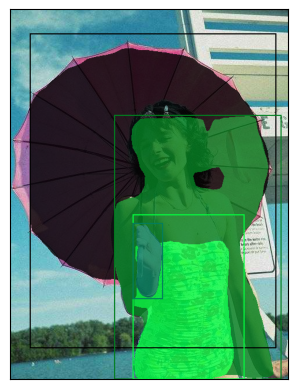

In [28]:
cpu_device = torch.device("cpu")

# load model from Mlflow artifact
run_id = run.info.run_id
model_path = f"runs:/{run_id}/model"
loaded_model = mlflow.pytorch.load_model(model_path)

# check models` device
print(f"device: {next(loaded_model.parameters()).device}, training: {loaded_model.training}")

resize_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale = True),
    v2.Resize((640, 640), antialias = True),
    v2.ToDtype(torch.float32, scale = True),
])

image_path = "../../../dataset/coco8-seg/valid/images/000000000036_jpg.rf.6783d468f8475090f3d3f214930df8aa.jpg"

ori_img = Image.open(image_path)
ori_img = transform(ori_img).unsqueeze(0).to(device)

image = Image.open(image_path)
image = resize_transform(image).unsqueeze(0).to(device)

# model.eval()

with torch.no_grad():
# with torch.inference_mode():
    output = loaded_model(image)
    masks = output[0]['masks'].squeeze(1).to(cpu_device)
    
    # total_mask = masks.sum(axis = 0)
    # total_mask = total_mask / total_mask.max()

    ori_height, ori_width = ori_img.squeeze(0).shape[1], ori_img.squeeze(0).shape[2]
    cur_height, cur_width = image.squeeze(0).shape[1], image.squeeze(0).shape[2]

    resized_masks = torch.empty((len(masks), ori_height, ori_width))

    for i, mask in enumerate(masks):
        masks_pil = Image.fromarray(mask.numpy())
        masks_resized = F.resize(masks_pil, [ori_height, ori_width])
        masks_resized_tensor = torch.from_numpy(np.array(masks_resized))
        resized_masks[i] = masks_resized_tensor

    masks_tensor_bool = resized_masks > 0.5

    boxes = output[0]['boxes'].to(cpu_device)
    width_scale = ori_width / cur_width
    height_scale = ori_height / cur_height

    scaled_boxes = []

    for box in boxes:
        scaled_box = [
            box[0] * width_scale, 
            box[1] * height_scale, 
            box[2] * width_scale, 
            box[3] * height_scale
        ]
        scaled_boxes.append(scaled_box)

    scaled_boxes_tensor = torch.tensor(scaled_boxes)

    scores = output[0]['scores'].to(cpu_device)

    keep = nms(boxes, scores, iou_threshold = 0.5)
    scaled_boxes_tensor = scaled_boxes_tensor[keep]
    masks_tensor_bool = masks_tensor_bool[keep]

    image_uint8 = (ori_img.squeeze(0) * 255).to(torch.uint8)
    result = draw_segmentation_masks(image_uint8, masks = masks_tensor_bool, alpha = 0.8)
    # colors = ['red'] * len(scaled_boxes_tensor)
    # result_with_boxes = draw_bounding_boxes(result, scaled_boxes_tensor, width = 5, colors = colors)
    result_with_boxes = draw_bounding_boxes(result, scaled_boxes_tensor, width = 2)

    show(result_with_boxes)

#### 6. Model Register

In [29]:
# function to retrieve experiment id based on experiment name
def get_experiment_id(client, name):
    experiments = client.search_experiments()
    for exp in experiments:
        if exp.name == name:
            return exp.experiment_id

# get experiment id
client = MlflowClient(tracking_uri = mlflow_tracking_url)
experiment_id = get_experiment_id(client, experiment_name)

print(f"the experiement id is: {experiment_id}")

the experiement id is: 1


In [31]:
# search for the top 3 lowest training loss
top_3_lowest_training_loss = client.search_runs(
    experiment_ids = experiment_id,
    filter_string = "metrics.total_train_loss < 0.4 and tags.model = 'mask_rcnn_resnet50_fpn_v2' and attributes.status = 'FINISHED'",
    run_view_type = ViewType.ACTIVE_ONLY,
    max_results = 3,
    order_by = ["metrics.total_train_loss ASC"]
)

# print(top_3_lowest_training_loss)

for tl in top_3_lowest_training_loss:
    print(f"run id: {tl.info.run_id}, total_train_loss: {tl.data.metrics['total_train_loss']:.4f}")

# df = pd.DataFrame({
#     'run_id': [run.info.run_id for run in top_3_lowest_training_loss],
#     'experiment_id': [run.info.experiment_id for run in top_3_lowest_training_loss],
#     'status': [run.info.status for run in top_3_lowest_training_loss],
#     'total_train_loss': [run.data.metrics['total_train_loss'] for run in top_3_lowest_training_loss]
# })

# get the first run id that has the most lowest training loss
run_id = top_3_lowest_training_loss[0].info.run_id
model_uri = f"runs:/{run_id}/model"
model_register_name = "coco8-inst-detection"

# register the model
mlflow.register_model(
    model_uri = model_uri, 
    name = model_register_name,
    # tags = { "run_id": run_id }
)

# register the model directly to 'Staging'
# model_detail = mlflow.register_model(
#     model_uri = model_uri, 
#     name = "coco8-inst-detection"
# )

# mlflow.tracking.MlflowClient().transition_model_version_stage(
#     name = "coco8-inst-detection",
#     version = model_detail.version,
#     stage = "Staging",
# )

run id: e93456ef786247b796725895020b134a, total_train_loss: 0.3711
run id: 5976610b76c948209a916e82c3503506, total_train_loss: 0.3765
run id: e555d198a23b427cb3f4edb606fe2b17, total_train_loss: 0.3977


TypeError: register_model() got an unexpected keyword argument 'description'

In [24]:
model_version = 3
new_stage = "Staging"
date = datetime.today().date()

# transition the model version to the "Staging" stage
client.transition_model_version_stage(
    name = model_register_name,
    version = model_version,
    stage = new_stage,
    archive_existing_versions = False
)

# update the model version description
client.update_model_version(
    name = model_register_name,
    version = model_version,
    description = f"The model version {model_version} was transitioned to {new_stage} on {date}"
)

C:\Users\christopher_hu\AppData\Local\Temp\ipykernel_3336\1242162667.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.1/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1715581624498, current_stage='Staging', description=None, last_updated_timestamp=1715581839916, name='coco8-inst-detection', run_id='56d6fb7910a449728e659f0ddeac064a', run_link=None, source='file:///D:/Git/computer-vision-deep-learning-project/project/instance_segmentation/coco8_seg/mlruns/1/56d6fb7910a449728e659f0ddeac064a/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [ ]:
new_stage = "Production"
date = datetime.today().date()

# transition the model version to the "Production" stage
client.transition_model_version_stage(
    name = "coco8-inst-detection",
    version = model_version,
    stage = new_stage,
    archive_existing_versions = True
)

# update the model version description
client.update_model_version(
    name = model_register_name,
    version = model_version,
    description = f"The model version {model_version} was transitioned to {new_stage} on {date}"
)

C:\Users\christopher_hu\AppData\Local\Temp\ipykernel_16652\2808647794.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.1/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1715329364199, current_stage='Production', description=None, last_updated_timestamp=1715329394258, name='coco8-inst-detection', run_id='fe677b99a3554f238009d03b08cc3fb6', run_link=None, source='file:///d:/Git/computer-vision-deep-learning-project/project/instance_segmentation/coco8_seg/mlruns/1/fe677b99a3554f238009d03b08cc3fb6/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>